# Индивидуальный проект по машинному обучению Д. Помогаев

## Идея
С сентября 2023 года в МФТИ работает Е. Толасова -- специалист по общественным связям. Под её руководством Пресс-служба МФТИ резко сменила вектор своей деятельности и заметно поменялся образ по которому служба публикует информацю  в социальных сетях. В этом проекте я пытаюсь обучить модель, которая может по тексту поста в сообществе определить он был написан при новой инфополитике или старой

## Использующиеся данные
1. Выгрузка полной информации о постах в сообществе МФТИ - Физтех в ВК с 2013 года
2. Выгрузка полной информации о последних 100 постах в сообществе МКИ (Студсовет МФТИ)
3. Модифицированный список служебных слов русского языка
4. Дата вступления Екатерины Толасовой в должность: 4 сентября 2023 года

## Использующиеся библиотеки
1. pandas - обработка табличных данных
2. wc - визуализация наиболее часто встречающихся слов
3. plotly - интерактивные графики
4. matplotlib - статичные графики и картинки
5. (Стандартная библиотека Python) - datetime, json, re
6. scikit-learn - Машинное Обучение
7. statsmodels - используется lowess для сглаживания кривых при построении

## Ограничения
1. Для обучения моделей используется только текст поста. Другая мета-информация вроде наличия и количества вложений или активность под публикацией опускаются
2. Модель должна обучаться меньше 30 минут

# Подготовка данных

In [3]:
import pandas as pd
import wordcloud as wc
import plotly.express as px
import datetime
from matplotlib import pyplot as plt

THE_DAY = datetime.datetime(2023, 9, 4)  # The Day E. Tolasova started working in MIPT

TOPN = 200  # How many unique words are used for ML

In [4]:
import re
ptr = re.compile(r"'count': (\d+)")

def seek_count(value: str):  # Extracting comment, view, like, repost counts from the given table
    if not isinstance(value, str):
        return None
    val = ptr.search(value)
    if val is not None:
        return int(val.group(1))
    else:
        print("Weird value found:", val)

Убираем из таблицы множество колонок, которые не понадобятся в дальнейшем

In [5]:
df = pd.read_excel("reports/1 (2).xlsx")
df = df.drop(["geo", "inner_type", "from_id", "type", "copy_history", "zoom_text", "signer_id", "copyright", "hash", "marked_as_ads", "owner_id", "Unnamed: 0"], axis=1)
c_cols = ["comments", "likes", "views", "reposts"]
df

comments  ...        edited
0      {'count': 0}  ...           NaN
1      {'count': 0}  ...           NaN
2      {'count': 0}  ...           NaN
3      {'count': 0}  ...           NaN
4      {'count': 1}  ...           NaN
...             ...  ...           ...
9395   {'count': 0}  ...  1.332199e+09
9396   {'count': 0}  ...  1.331223e+09
9397  {'count': 16}  ...           NaN
9398   {'count': 4}  ...  1.330588e+09
9399   {'count': 0}  ...           NaN

[9400 rows x 10 columns]

Дополнительно чистим имеющиеся данные

In [6]:
for col in c_cols:
    df[col] = df[col].apply(seek_count)
df["attachments"] = df["attachments"].apply(lambda s: s != "[]")
df["edited"] = ~df["edited"].isna()
df["text"] = df["text"].fillna("")
df["date"] = pd.to_datetime(df["date"])
df

comments  attachments  ...   views  edited
0            0         True  ...  1115.0   False
1            0        False  ...  1972.0   False
2            0         True  ...  1413.0   False
3            0         True  ...  1383.0   False
4            1         True  ...  2223.0   False
...        ...          ...  ...     ...     ...
9395         0        False  ...     NaN    True
9396         0        False  ...     NaN    True
9397        16        False  ...     NaN   False
9398         4        False  ...     NaN    True
9399         0        False  ...     NaN   False

[9400 rows x 10 columns]

Вводим временную метрику "длина поста"

In [7]:
df["len_text"] = df["text"].apply(lambda s: len(s.split()))
df


comments  attachments                date  ...   views  edited len_text
0            0         True 2024-09-10 18:00:01  ...  1115.0   False       53
1            0        False 2024-09-10 16:27:07  ...  1972.0   False        0
2            0         True 2024-09-10 14:48:45  ...  1413.0   False       96
3            0         True 2024-09-10 13:56:06  ...  1383.0   False      124
4            1         True 2024-09-10 12:14:11  ...  2223.0   False      107
...        ...          ...                 ...  ...     ...     ...      ...
9395         0        False 2012-03-20 02:20:58  ...     NaN    True       50
9396         0        False 2012-03-08 19:12:28  ...     NaN    True        0
9397        16        False 2012-03-01 17:39:00  ...     NaN   False        0
9398         4        False 2012-03-01 11:14:20  ...     NaN    True        0
9399         0        False 2012-02-29 16:05:36  ...     NaN   False        0

[9400 rows x 11 columns]

Вводим флаг для обучения - пост был опубликован при Е.Толасовой или до этого

In [8]:
df["with_Tol"] = df["date"] > THE_DAY
df

comments  attachments                date  ...  edited  len_text with_Tol
0            0         True 2024-09-10 18:00:01  ...   False        53     True
1            0        False 2024-09-10 16:27:07  ...   False         0     True
2            0         True 2024-09-10 14:48:45  ...   False        96     True
3            0         True 2024-09-10 13:56:06  ...   False       124     True
4            1         True 2024-09-10 12:14:11  ...   False       107     True
...        ...          ...                 ...  ...     ...       ...      ...
9395         0        False 2012-03-20 02:20:58  ...    True        50    False
9396         0        False 2012-03-08 19:12:28  ...    True         0    False
9397        16        False 2012-03-01 17:39:00  ...   False         0    False
9398         4        False 2012-03-01 11:14:20  ...    True         0    False
9399         0        False 2012-02-29 16:05:36  ...   False         0    False

[9400 rows x 12 columns]

Исследуем, как менялась статистика взаимодействий с постами. Линии сглаживаются методом lowess, красной полоской отмечено вступление Е. Толасовой в должность

In [9]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig: go.Figure = make_subplots(
    rows=4, cols=1, shared_xaxes=True,
    subplot_titles=['Views', 'Likes', 'Reposts', 'Post lengths']
)
fig.update_layout(height=1200)
df["date_day"] = df["date"].apply(lambda t: t.date())
by_day_df = df.groupby("date_day")[["likes", "reposts", "comments", "views"]].mean().reset_index()

y = lowess(by_day_df['views'], by_day_df.index, frac=0.03)
fig.add_trace(go.Scatter(x=by_day_df["date_day"][y[:, 0]], y=y[:, 1], mode='lines', name='views'), row=1, col=1)

y = lowess(by_day_df['likes'], by_day_df.index, frac=0.03)
fig.add_trace(go.Scatter(x=by_day_df["date_day"][y[:, 0]], y=y[:, 1], mode='lines', name='likes'), row=2, col=1)

y = lowess(by_day_df['reposts'], by_day_df.index, frac=0.03)
fig.add_trace(go.Scatter(x=by_day_df["date_day"][y[:, 0]], y=y[:, 1], mode='lines', name='reposts'), row=3, col=1)

bdf = df[df["len_text"] > 0].groupby("date_day")["len_text"].mean().reset_index()
y = lowess(bdf['len_text'], bdf.index, frac=0.03)
fig.add_trace(go.Scatter(x=bdf["date_day"][y[:, 0]], y=y[:, 1], mode='lines', name='text length'), row=4, col=1)

fig.add_vline(x=THE_DAY, line_color="red")
fig.update_layout(title="MIPT community stats of all time")

Аггрегируем весь текст со всех постов для построения рейтинга самых часто используемых слов

В процессе удаляются служебные части речи, а также ссылки и пунктуация. Методов нормализации склонения пока не обнаружено, что в теории может привести к искажению частоты для часто склоняемых слов

Так, например, слово физтех в верхушке рейтинга встречается в 4 формах: физтех, физтеха, физтехе, физтехов

In [10]:
words = []
with open("assets/not_words.txt", encoding='utf-8') as f:
    not_words = set(f.read().splitlines())
len(not_words)
for e in ["miptru", "vkcc"]:
    not_words.add(e)


for m in df["text"]:
    m: str
    for word in m.split():
        # remove punctuation
        word = "".join([c for c in word if c.isalpha() or c=='-']).lower()
        if word not in not_words:
            words.append(word)
text = " ".join(words)

Отдельно строим wc для периода работы Е. Толасовой. Может быть заметно изменилось распределние самых частых слов?

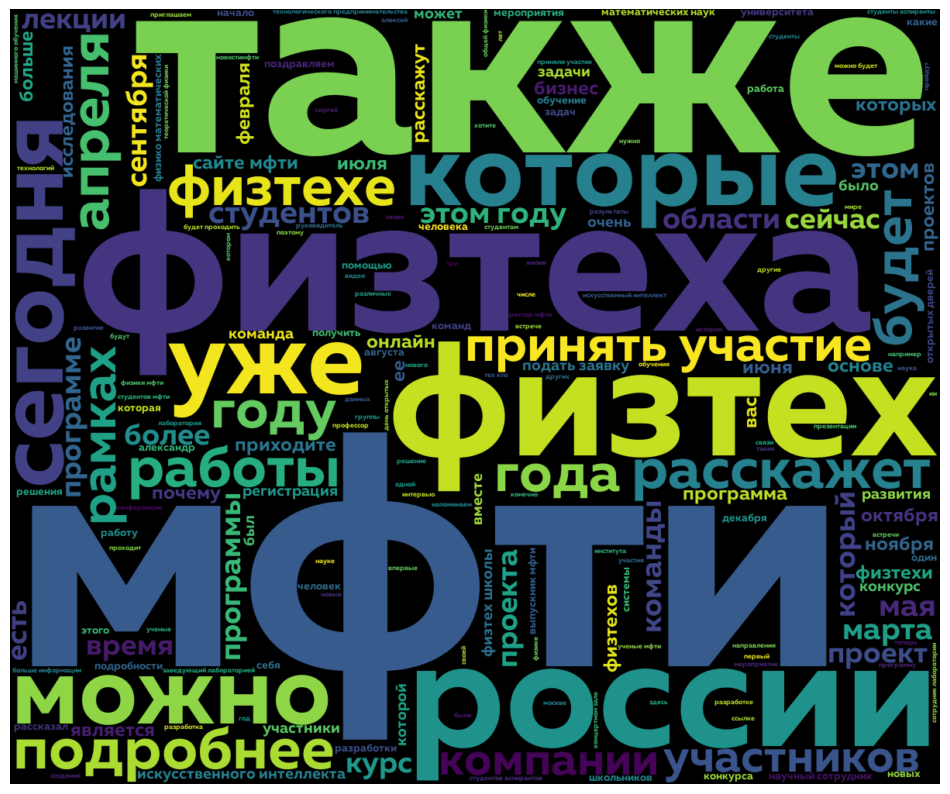

In [11]:
words = []
with open("assets/not_words.txt", encoding='utf-8') as f:
    not_words = set(f.read().splitlines())
len(not_words)
for e in ["miptru", "vkcc", "", "-"]:
    not_words.add(e)


for m in df["text"]:
    m: str
    for word in m.split():
        # remove punctuation
        word = "".join([c for c in word if c.isalpha() or c=='-']).lower()
        if word not in not_words:
            words.append(word)
text = " ".join(words)

wdc = wc.WordCloud("assets/Fontfabric - MullerBold.otf", 1200, 1000).generate_from_text(text)

plt.figure(figsize=(12, 12))
plt.imshow(wdc, interpolation='bilinear', cmap="magma")
plt.axis("off")
plt.show()

In [12]:
wdf = pd.DataFrame(words, columns=["words"])
w_ranking = wdf.groupby(words).count().reset_index(names="word").sort_values("words", ascending=False).reset_index(drop=True)

Самое часто встречающееся слово в сообществе = **МФТИ**. очень красиво и символично

In [13]:
w_ranking.loc[0, "word"]

'мфти'

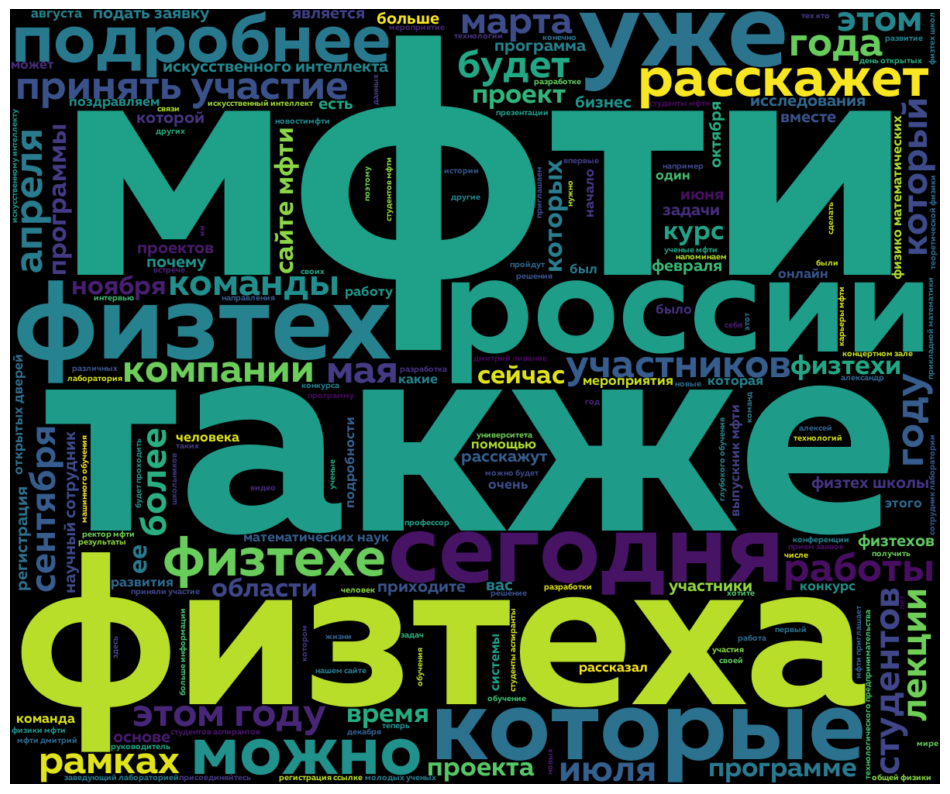

In [14]:
for m in df[df["date"] > THE_DAY]["text"]:
    m: str
    for word in m.split():
        # remove punctuation
        word = "".join([c for c in word if c.isalpha() or c=='-']).lower()
        if word not in not_words:
            words.append(word)
text = " ".join(words)

wdc = wc.WordCloud("assets/Fontfabric - MullerBold.otf", 1200, 1000).generate_from_text(text)

plt.figure(figsize=(12, 12))
plt.imshow(wdc, interpolation='bilinear', cmap="magma")
plt.axis("off")
plt.show()

wdf = pd.DataFrame(words, columns=["words"])
w_ranking_2 = wdf.groupby(words).count().reset_index(names="word").sort_values("words", ascending=False).reset_index(drop=True)

In [15]:
def print_over_4(l):
    i = 0
    for el in l:
        print(el, end=" ")
        i+=1
        if i == 4:
            print()
            i = 0

print_over_4(w_ranking.loc[:100, "word"])

мфти также можно будет 
физтеха года студентов участие 
сайте физики состоится будут 
области россии сегодня физтех 
студенты которые уже регистрация 
лаборатории году программы рамках 
пройдет физтехе технологий лекции 
апреля подробнее кафедры работы 
ран день этом института 
вас исследований вопросы ноября 
лекция центра науки систем 
время технологии физике место 
возможность обучения более наук 
мая компании курса ссылке 
расскажет курс развития научных 
проекта который марта октября 
есть больше получить могут 
программа сентября лет вузов 
свои конференции директор программе 
может конкурса необходимо кто 
команды университета ученые гк 
проект профессор школы конкурс 
выпускников участники александр руководитель 
проектов участников данных июня 
работе олимпиады научный новых 
математики 

Собираем окончательную таблицу для обучения: имеющую полную информацию о посте и количество упоминаний каждого слова из top-(100)

Функция `t100_counter` раскладывает текст в счётчик из `TOPN` самых часто используемых слов. Таким образом входными данными для обучения являются количества упоминаний конкретных слов. Все остальные слова на данном этапе откидываются

In [16]:
t100 = w_ranking.loc[:TOPN, "word"].to_list()  # top 100 words used in posts

def t100_counter(t: str):
    return pd.Series([t.count(w) for w in t100], index=t100)

df_exp = pd.concat([df, df["text"].apply(t100_counter)], axis=1)

## Подбор модели
Выбором по сетке гиперпараметров моделей с оценкой через 5-fold, подбираем модель, лучше всего описывающую имеющиеся данные

Модели выбираются из ансамблевых методов: Случайный лес, AdaBoost и Градиентный бустинг

Перед обучением выборка делится на рабочую и подтверждающую. Обучение моделей идёт на рабочих данных, оценка моделей для сравнения между собой производится на подтиверждающей выборке во избежание выбора переобученной модели

In [17]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

In [18]:
X_train, X_verify, y_train, y_verify = train_test_split(df_exp[t100], df_exp["with_Tol"], random_state=42, train_size=0.8)


d = {'n_estimators': [50, 100, 150, 250, 300]}
clf = RandomForestClassifier()
clfg = GridSearchCV(clf, d)
clfg.fit(X_train, y_train)
clfg.score(X_verify, y_verify)

0.8776595744680851

In [19]:
d = {'n_estimators': [20, 35, 50, 75, 100]}
ada = AdaBoostClassifier()
adag = GridSearchCV(clf, d)
adag.fit(X_train, y_train)
adag.score(X_verify, y_verify)

0.8803191489361702

In [20]:
d = {'learning_rate': [0.05, 0.1, 0.2]}
grb = GradientBoostingClassifier()
grbg = GridSearchCV(grb, d)
grbg.fit(X_train, y_train)
grbg.score(X_verify, y_verify)

0.875

До этого обучение проводилось призначении `topN = 100`. Увеличение количестве учитываемых слов до 250 не увеличило точность моделей

score считает accuracy моделей

## Вывод
Для решения этой задачи лучше всего подходит обучение случайными лесами с 250 etimators

# Кластеризация данных

Пробуем кластеризовать данные. Может быть получится снизить размерность данных до 2

## PCA + ICA

In [21]:
from sklearn.decomposition import PCA, FastICA

df_exp[["PCA1", "PCA2"]] = pd.DataFrame(PCA(n_components=2).fit_transform(df_exp[t100]), columns=["PCA1", "PCA2"])
px.scatter(df_exp, x="PCA1", y="PCA2", color="with_Tol")

In [22]:
df_exp[["ICA1", "ICA2"]] = pd.DataFrame(FastICA(n_components=2).fit_transform(df_exp[t100]), columns=["ICA1", "ICA2"])
px.scatter(df_exp, x="ICA1", y="ICA2", color="with_Tol")

## Manifolding with Isomap and TSNE

In [23]:
from sklearn.manifold import TSNE, Isomap

In [24]:
df_exp[["TSNE1", "TSNE2"]] = pd.DataFrame(TSNE(n_components=2).fit_transform(df_exp[t100]), columns=["TSNE1", "TSNE2"])
px.scatter(df_exp, x="TSNE1", y="TSNE2", color="with_Tol")

In [25]:
df_exp[["Iso1", "Iso2"]] = pd.DataFrame(Isomap(n_components=2).fit_transform(df_exp[t100]), columns=["Iso1", "Iso2"])
px.scatter(df_exp, x="Iso1", y="TSNE2", color="with_Tol")

## Выводы

Кластеризация не помогает решить задачу на представленных данных. Не при использовании 2 компонент.

Тем не менее, группировка постов при использовании TSNE происходит. Увы, разделения постов на необходимые две группы не наблюдается

# Использования модели для аналаиза других интересных вещей

Проверяем как модель работает на одиночных примерах. Ради инетереса

In [26]:
ttext, tbool = df.loc[[237, 5671], "text"], df.loc[[237, 5671], "with_Tol"]
tcount = ttext.apply(t100_counter)

Теперь посмотрим, можно ли эту метрику использовать для анализа постов других сообществ, например МКИ (Студсовет МФТИ)

In [27]:
import json
with open('reports/MKI_wall.json', encoding='utf-8') as f:
    data = json.load(f)['response']['items']

mki_df = pd.read_json(json.dumps(data))
# mki_df

C:\Users\Redencon\AppData\Local\Temp\ipykernel_76856\2873652992.py:5: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [28]:
mki_df["like_Tol"] = clfg.best_estimator_.predict(mki_df["text"].apply(t100_counter))

In [29]:
mki_df[mki_df["like_Tol"]]["id"].apply(print)

12159
11822


88    None
99    None
Name: id, dtype: object

Получаем, что МКИ в большинстве своём пишет посты, не похожие по стилю написанию на новую инфополитику МФТИ.

# Верификация, что точность не получена низким количеством данных одной группы

In [30]:
from sklearn.metrics import confusion_matrix

In [32]:
allx = df_exp[t100]
ally = df_exp["with_Tol"]
allYp = clfg.best_estimator_.predict(allx)

cf = confusion_matrix(ally, allYp, normalize='true')

fig = px.imshow(cf, text_auto=True, title="Confusion matrix")
fig.update_xaxes(title="Predicted")
fig.update_yaxes(title="True")